In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import lognorm, weibull_min, t, norm
from scipy.stats import t, norm
from scipy.linalg import cholesky

In [2]:
# simulated historical data
np.random.seed(42)
n_obs = 1000
mu_H, sigma_H = 0.5, 0.2 # hurricane parameters (log-normal)
k_E, lambda_E = 1.5, 2.0 # earthquake parameters (Weibull)

# parameters for t-copula
rho = 0.6
df = 5

# simulate uniform random variables
n_simulations = 1000
u = np.random.uniform(0, 1, (n_simulations, 2))


# apply inverse CDF for t-copula
t_copula = t(df).ppf(u)

# transform using the correlation matrix
corr_matrix = np.array([[1, rho], [rho, 1]])
cholesky_decomp = np.linalg.cholesky(corr_matrix)
z = np.dot(t_copula, cholesky_decomp.T)



# convert t-copula samples to uniform marginals
u_copula = norm.cdf(z)

In [3]:
# Apply inverse marginal CDFs
hurricane_losses = lognorm(sigma_H, scale=np.exp(mu_H)).ppf(u_copula[:, 0])
earthquake_losses = weibull_min(k_E, scale=lambda_E).ppf(u_copula[:, 1])

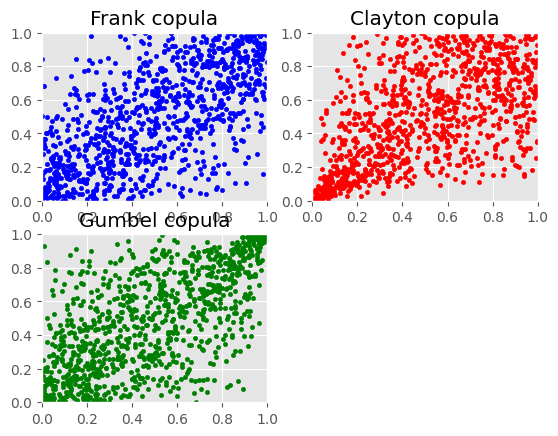

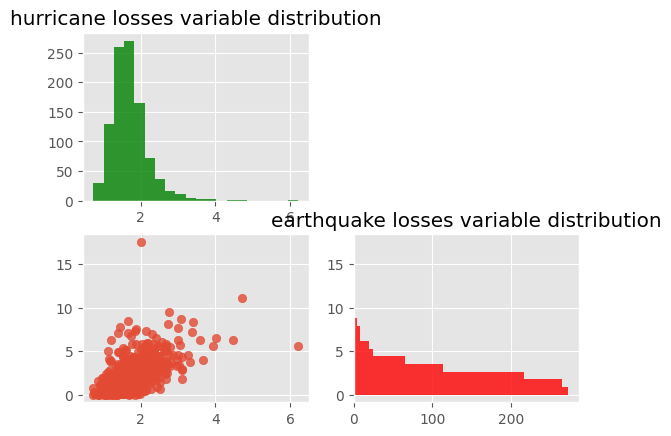

In [4]:
from copulalib.copulalib import Copula
plt.style.use('ggplot')

def generateData():
    global x,y
    x = hurricane_losses
    y = earthquake_losses

# Data and histograms
def plotData():
    global x,y
    fig = plt.figure()
    fig.add_subplot(2,2,1)
    plt.hist(x,bins=20,color='green',alpha=0.8,align='mid')
    plt.title('hurricane losses variable distribution')
    fig.add_subplot(2,2,3)
    plt.scatter(x,y,marker="o",alpha=0.8)
    fig.add_subplot(2,2,4)
    plt.title('Joint X,Y')
    plt.hist(y,bins=20,orientation='horizontal',color='red',alpha=0.8,align='mid')
    plt.title('earthquake losses variable distribution')    
    plt.show()

def generateCopulas():
    global x,y
    fig = plt.figure()

    frank = Copula(x,y,family='frank')
    uf,vf = frank.generate_uv(1000)
    fig.add_subplot(2,2,1)
    plt.scatter(uf,vf,marker='.',color='blue')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.title('Frank copula')

    clayton = Copula(x,y,family='clayton')
    uc,vc = clayton.generate_uv(1000)
    fig.add_subplot(2,2,2)
    plt.scatter(uc,vc,marker='.',color='red')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.title('Clayton copula')

    gumbel = Copula(x,y,family='gumbel')
    ug,vg = gumbel.generate_uv(1000)
    fig.add_subplot(2,2,3)
    plt.scatter(ug,vg,marker='.',color='green')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.title('Gumbel copula')

    plt.show()


generateData()
generateCopulas()
plotData()


Clayton seems to show the best results 

In [5]:
# calculate total losses and apply bond terms
attachment_point = 100
exhaustion_point = 300
coverage = 200 # bond face -value

total_losses = (hurricane_losses + earthquake_losses) * 100
payouts = np.clip((total_losses - attachment_point) / (exhaustion_point - attachment_point) * coverage, None, coverage, out=None)

# expected Loss
expected_loss = np.mean(payouts)

In [6]:
# probability of exceedance
prob_exceed_attachment = np.mean(total_losses > attachment_point)
prob_exceed_exhaustion = np.mean(total_losses > exhaustion_point)

print(f"Expected Loss: ${expected_loss:.2f} million")
print(f"Probability of Exceeding Attachment Point: {prob_exceed_attachment:.2%}")
print(f"Probability of Exceeding Exhaustion Point: {prob_exceed_exhaustion:.2%}")

Expected Loss: $161.57 million
Probability of Exceeding Attachment Point: 99.10%
Probability of Exceeding Exhaustion Point: 56.00%
